In [1]:
# Import all the necessary libraries.
import numpy as np
import timeit
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from datetime import datetime
from datetime import timedelta
import json
import requests
import pandas as pd
import tqdm
import warnings
import csv

## Vectors Reading

In [2]:
df = pd.read_csv('./covid19.csv', header=None)

x = df[0].to_numpy()
y = df[1].to_numpy()

X =  x.reshape(len(y), 1)
y =  y.reshape(len(y), 1)

include_bias = False

## Days of Disease vs. Active cases

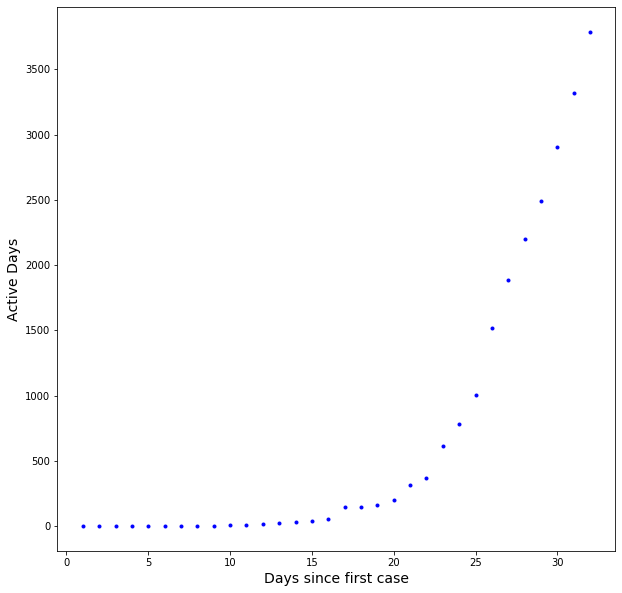

In [3]:
fig = plt.figure(figsize=(10,10))
plt.plot(x, y, 'b.')
plt.xlabel('Days since first case',  fontsize=14)
plt.ylabel('Active Days',  fontsize=14)
plt.show()

## Holdout cross-validation (80/20%)

In [4]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Split the whole set into random training and validation set.
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print('Size of Training Set:', len(y_train))
print('Size of Validation Set:', len(y_val))

error_train = []
error_val = []
mean_vec = []
std_vec = []
for d in range(1, 13):
    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])
    
    # Perform polynomial regression.
    polynomial_regression.fit(x_train, y_train)
    
    y_train_predict = polynomial_regression.predict(x_train)
    
    y_val_predict = polynomial_regression.predict(x_val)    
    
    error_train.append(np.sqrt(mean_squared_error(y_train, y_train_predict)))

    error_val.append(np.sqrt(mean_squared_error(y_val, y_val_predict)))

print("Tempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))    

Size of Training Set: 25
Size of Validation Set: 7
Tempo de execução: 0.1843 [s]


## Mean Square Error vs. Polynomial order - Holdout

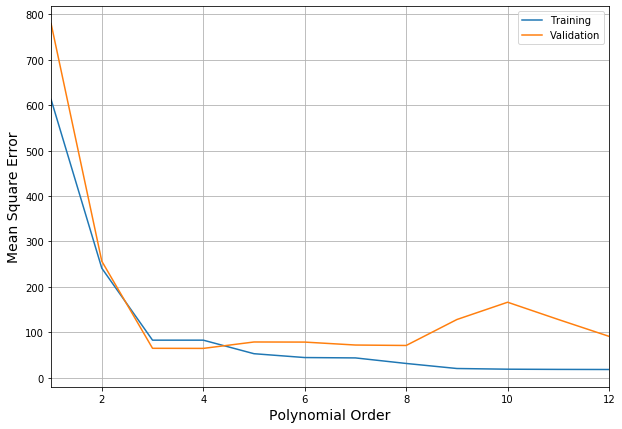

In [5]:
# Plot results.
plt.figure(figsize=(10, 7))
plt.plot(range(1, 13), error_train, label='Training')
plt.plot(range(1, 13), error_val, label='Validation')
plt.xlabel('Polynomial Order',  fontsize=14)
plt.ylabel('Mean Square Error',  fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()
#Show the plot.
plt.show()

## K-fold cross validation (k=10)

In [6]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Instantiate the k-Fold object.
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

error_train = []
error_val = []
mean_vec = []
std_vec = []
for d in range(1, 13):
    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    lin_scores = cross_val_score(polynomial_regression, X, y, scoring='neg_mean_squared_error', cv=kfold)
    
    scores = np.sqrt(-lin_scores)
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())

print("Tempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))    

Tempo de execução: 0.8298 [s]


## Mean Square Error and Standard Deviation - K-fold

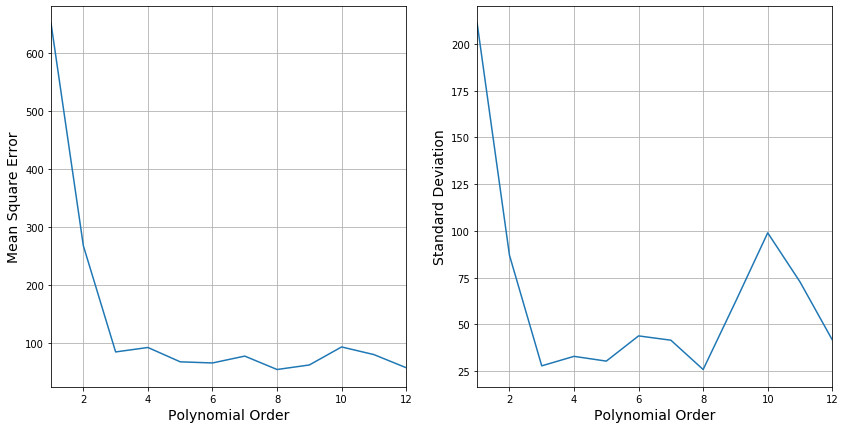

In [7]:
# Plot results.
plt.figure(figsize=(14, 7))
ax = plt.subplot(1, 2, 1)
plt.plot(range(1, 13), mean_vec)
plt.xlabel('Polynomial Order',  fontsize=14)
plt.ylabel('Mean Square Error',  fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(range(1, 13), std_vec)
plt.xlabel('Polynomial Order',  fontsize=14)
plt.ylabel('Standard Deviation',  fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.grid()

#Show the plot.
plt.show()

   ## Leave-p-out cross-validation (p=1)

In [8]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Instantiate the LPOCV object.
lpocv = LeavePOut(p=1)

mean_vec = []
std_vec = []
for d in range(1, 13):
    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    lin_scores = cross_val_score(polynomial_regression, X, y, scoring='neg_mean_squared_error', cv=lpocv)
        
    scores = np.sqrt(-lin_scores)
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())
    
print("Tempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))


Tempo de execução: 2.6791 [s]


## Mean Square Error and Standard Deviation - Leave-p-out

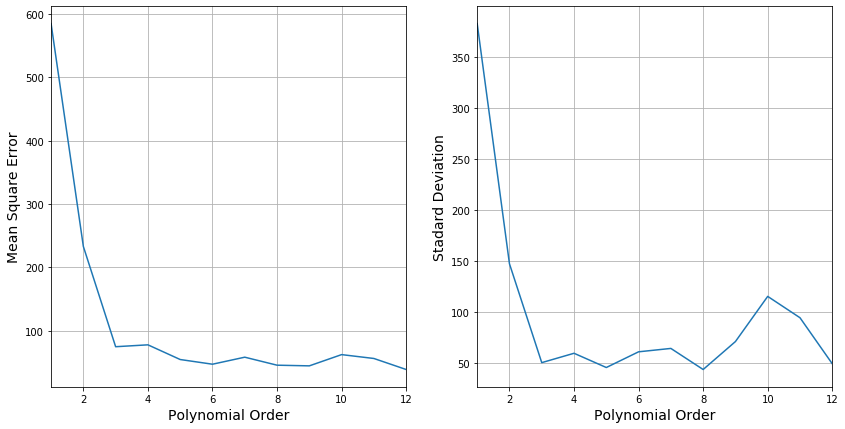

In [9]:
# Plot results.
plt.figure(figsize=(14, 7))
ax = plt.subplot(1, 2, 1)
plt.plot(range(1, 13), mean_vec)
plt.xlabel('Polynomial Order', fontsize=14)
plt.ylabel('Mean Square Error', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(range(1, 13), std_vec)
plt.xlabel('Polynomial Order', fontsize=14)
plt.ylabel('Stadard Deviation', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.grid()

#Show the plot.
plt.show()

## Learning-curves

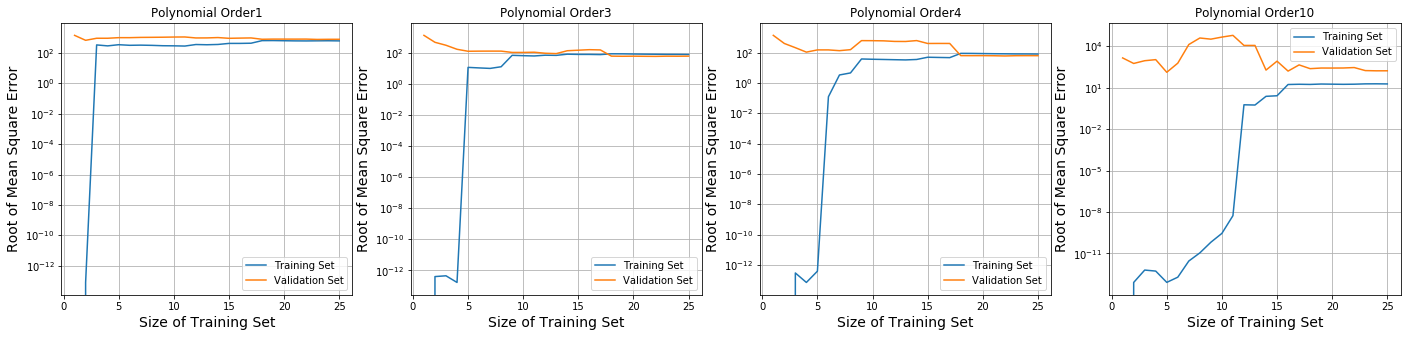

In [10]:
degrees = [1, 3, 4, 10]

plt.figure(figsize=(24, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=degrees[i], include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    error_training = []
    error_validation = []
    error_test = []
    for m in range(1,len(x_train)+1):

        # Perform polynomial regression.
        polynomial_regression.fit(x_train[:m], y_train[:m])

        # Use the trained model for prediction of the training set.
        y_train_predict = polynomial_regression.predict(x_train[:m])

        # Use the trained model for prediction of the validation set.
        y_val_predict = polynomial_regression.predict(x_val)       

        # Calculate MSE for training set.
        error_training.append(mean_squared_error(y_train[:m], y_train_predict))

        # Calculate MSE for validation set.
        error_validation.append(mean_squared_error(y_val, y_val_predict))     

    plt.plot(range(1,len(x_train)+1), np.sqrt(error_training), label='Training Set')
    plt.plot(range(1,len(x_train)+1), np.sqrt(error_validation), label='Validation Set')
    plt.yscale('log')
    plt.xlabel('Size of Training Set', fontsize=14)
    plt.ylabel('Root of Mean Square Error', fontsize=14)
    plt.grid()
    plt.title('Polynomial Order'+str(degrees[i]))
    plt.legend(loc='best')
    
#Show the plot.
plt.show()

## Model training

In [11]:
# Best polynomial order
degree = 3

include_bias = False

# Instantiate a polynomial with the given degree.
poly_features = PolynomialFeatures(degree=degree, include_bias=include_bias)
# Instantiate a scaler that will standardize the features.
std_scaler = StandardScaler()
# Instantiate a linear regressor.
lin_reg = LinearRegression()

# Create a pipeline of actions.
model = Pipeline([
    ("poly_features", poly_features),
    ("std_scaler", std_scaler),
    ("lin_reg", lin_reg),
])

# Train model.
model.fit(X, y)

# Perform prediction for 70 days.
X_pred = np.arange(1, 70).reshape(-1, 1)
y_pred = model.predict(X_pred)
X_pred = X_pred.reshape(1, -1)[0]

## Prediction of active cases after 70 days

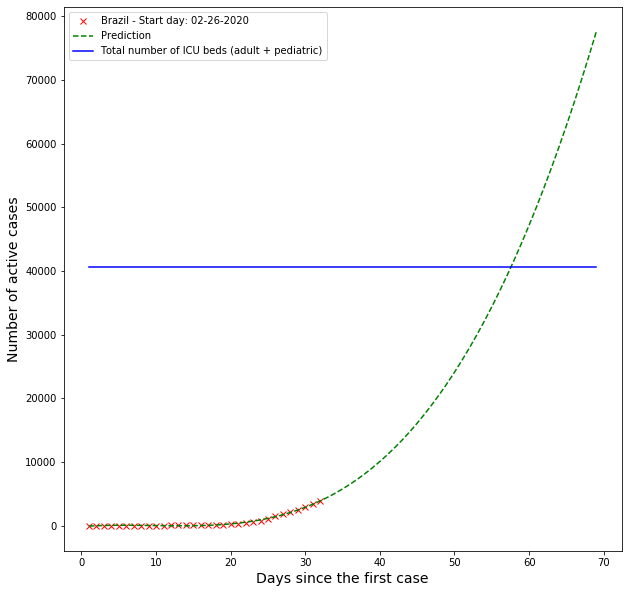

In [12]:
plt.figure(figsize=(10, 10))
plt.plot(X,y,'rx',label='Brazil - Start day: 02-26-2020')
plt.plot(X_pred,y_pred,'g--',label='Prediction')
plt.plot(X_pred,40600*np.ones(len(X_pred)),'b',label='Total number of ICU beds (adult + pediatric)')
plt.xlabel('Days since the first case', fontsize=14)
plt.ylabel('Number of active cases', fontsize=14)
plt.legend()
plt.show()

## Collapse of ICU beds

In [13]:
colapso_de_leitos_UTI = min([i+1 for i,v in enumerate(y_pred) if v >= 40600])
print('Collapse of ICU beds: ', colapso_de_leitos_UTI)

Collapse of ICU beds:  58
